<a href="https://colab.research.google.com/github/Dharren09/Deep_Residual_Learning_on_Brain_Tumors/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install split-folders
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import pathlib
from PIL import Image
import splitfolders
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau
from tensorflow.keras import layers, models

In [ ]:
!unzip '/content/Brain_Tumor_Dataset.zip'

Archive:  /content/Brain_Tumor_Dataset.zip
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1).png  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1).tif  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (10).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (10).tif  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (100).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1000).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1001).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1002).JPG  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1003).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1004).jpg  
  inflating: B

In [ ]:
dataset_dir = '/content/Brain Tumor Data Set/Brain Tumor Data Set'
os.listdir(dataset_dir)

['Healthy', 'Brain Tumor']

In [ ]:
metadata = pd.read_csv('/content/metadata.csv')
metadata.drop(columns='Unnamed: 0', axis= 1, inplace=True)
print(metadata.head().to_markdown())

|    | image           | class   | format   | mode   | shape         |
|---:|:----------------|:--------|:---------|:-------|:--------------|
|  0 | Cancer (1).jpg  | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  1 | Cancer (1).png  | tumor   | PNG      | L      | (300, 240)    |
|  2 | Cancer (1).tif  | tumor   | TIFF     | RGB    | (256, 256, 3) |
|  3 | Cancer (10).jpg | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  4 | Cancer (10).tif | tumor   | TIFF     | RGB    | (256, 256, 3) |


In [ ]:
def read_and_visualize(data_path, n_images=3, n_columns=3, image_size=(224, 224), visualize=False):
  labels = []
  image_paths = []

  if not os.path.isdir(data_path):
    raise (f'Invalid directory path: {data_path}')

  classes = os.listdir(data_path)
  for cls_ in classes:
    class_path = os.path.join(data_path, cls_)
    if not os.path.isdir(class_path):
      continue

    class_image_paths = [os.path.join(class_path, im) for im in os.listdir(class_path)][:n_images // len(classes)]
    image_paths.extend(class_image_paths)
    labels.extend([cls_] * len(class_image_paths))

  if visualize:
    rows = (len(image_paths) + n_columns - 1) // n_columns
    fig, axes = plt.subplots(rows, n_columns, figsize=(15, 5*rows))

    for idx, image_path in enumerate(image_paths):
      image = Image.open(image_path).convert('RGB')
      image = image.resize(image_size)
      row = idx // n_columns
      col = idx % n_columns
      axes[row, col].imshow(image)
      axes[row, col].set_title(f'State: {classes[idx // (n_images // len(classes))]}, Image: {idx}')
      axes[row, col].axis('off')

    for j in range(len(image_paths), rows * n_columns):
      fig.delaxes(axes[j // n_columns, j % n_columns])

    plt.tight_layout()
    plt.show()

  return image_paths, labels

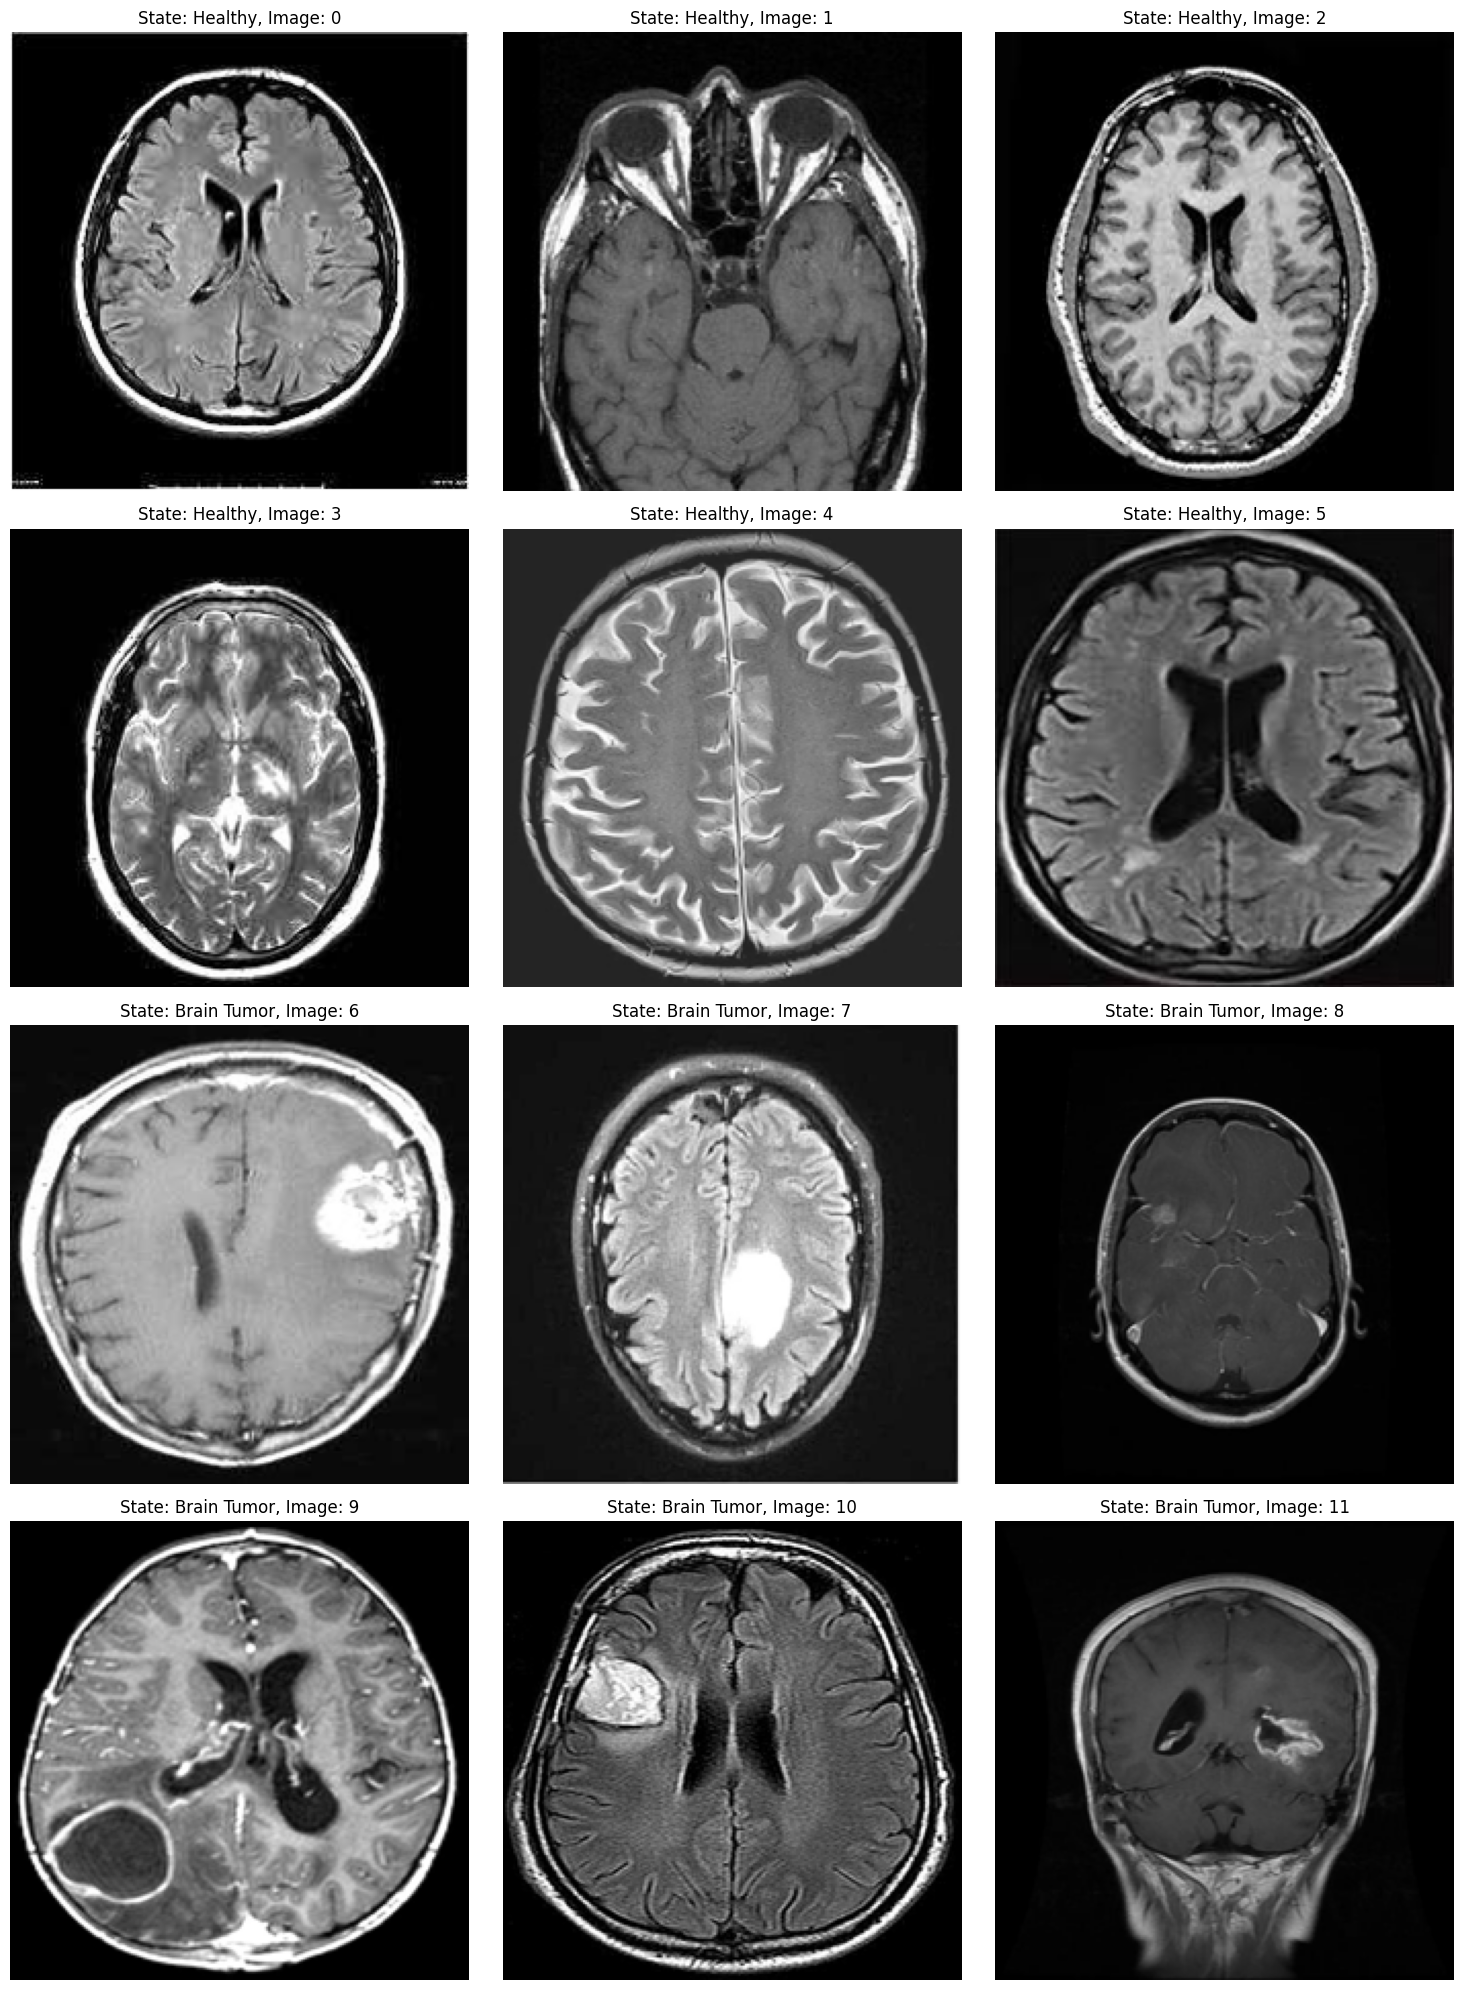

(['/content/Brain Tumor Data Set/Brain Tumor Data Set/Healthy/Not Cancer  (1467).jpg',
  '/content/Brain Tumor Data Set/Brain Tumor Data Set/Healthy/Not Cancer  (473).jpg',
  '/content/Brain Tumor Data Set/Brain Tumor Data Set/Healthy/Not Cancer  (1018).jpg',
  '/content/Brain Tumor Data Set/Brain Tumor Data Set/Healthy/Not Cancer  (1462).jpg',
  '/content/Brain Tumor Data Set/Brain Tumor Data Set/Healthy/Not Cancer  (540).jpg',
  '/content/Brain Tumor Data Set/Brain Tumor Data Set/Healthy/Not Cancer  (761).jpg',
  '/content/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1076).jpg',
  '/content/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1197).jpg',
  '/content/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (586).jpg',
  '/content/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1247).jpg',
  '/content/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (2174).jpg',
  '/content/Brain Tumor Data Set/Brain Tumor Data Se

In [ ]:
data_path = '/content/Brain Tumor Data Set/Brain Tumor Data Set'
read_and_visualize(data_path=data_path, n_images=12, n_columns=3, image_size=(224, 224), visualize=True)

In [ ]:
data_path = pathlib.Path('/content/Brain Tumor Data Set/Brain Tumor Data Set')

seed = 1332
ratio = (0.5, 0.25, 0.25)

splitfolders.ratio(data_path, ratio=ratio, seed=seed, output='TumorDataset')

data_path = '/content/TumorDataset'
data_dir = pathlib.Path(data_path)


Copying files: 4600 files [00:01, 3820.79 files/s]


In [ ]:
os.listdir(data_dir)

['val', 'train', 'test']

In [ ]:
count_dict = {}
dirs = os.listdir(data_dir)

# Loop through main directories (val, test, train)
for dir_ in dirs:
    sub_dir_path = os.path.join(data_dir, dir_)
    sub_dir_dict = {}

    # Loop through subdirectories within the current main directory (e.g., no, yes)
    for folder in os.listdir(sub_dir_path):
        # Count images in the sub-subdirectory
        image_count = 0
        for filename in os.listdir(os.path.join(sub_dir_path, folder)):
            if filename in count_dict.values():
                image_count = 1
            image_count += 1

        # Store count in subdirectory dictionary
        sub_dir_dict[folder] = image_count

    # Add subdirectory dictionary to main dictionary
    count_dict[dir_] = sub_dir_dict

count_dict

{'val': {'Healthy': 521, 'Brain Tumor': 628},
 'train': {'Healthy': 1043, 'Brain Tumor': 1256},
 'test': {'Healthy': 523, 'Brain Tumor': 629}}

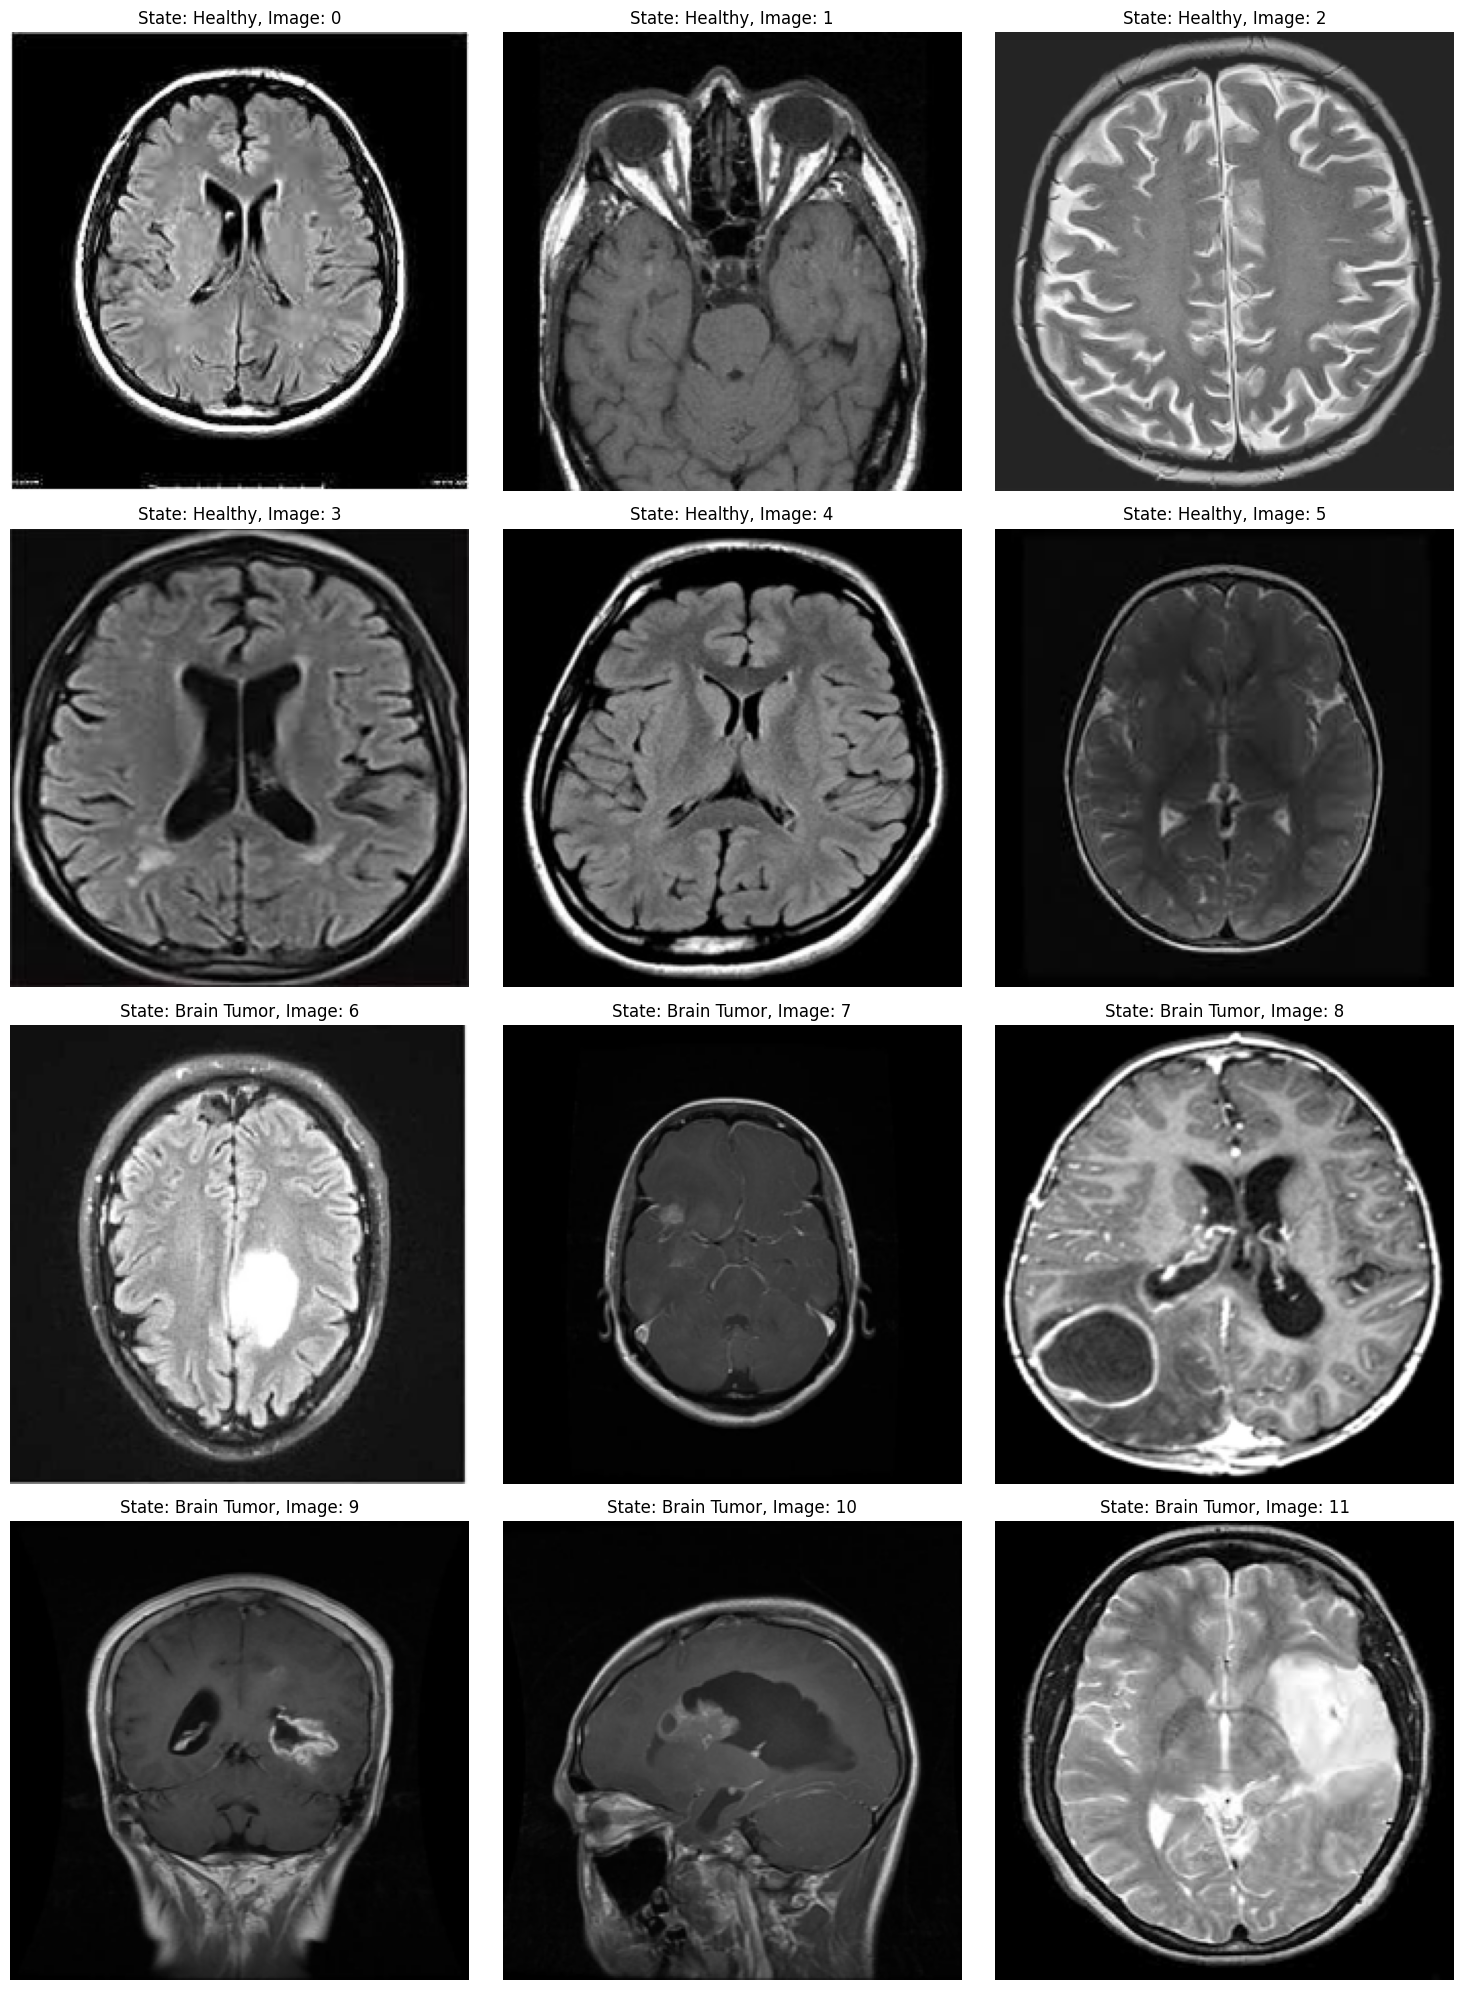

(['/content/TumorDataset/train/Healthy/Not Cancer  (1467).jpg',
  '/content/TumorDataset/train/Healthy/Not Cancer  (473).jpg',
  '/content/TumorDataset/train/Healthy/Not Cancer  (540).jpg',
  '/content/TumorDataset/train/Healthy/Not Cancer  (761).jpg',
  '/content/TumorDataset/train/Healthy/Not Cancer  (645).jpg',
  '/content/TumorDataset/train/Healthy/Not Cancer  (939).jpg',
  '/content/TumorDataset/train/Brain Tumor/Cancer (1197).jpg',
  '/content/TumorDataset/train/Brain Tumor/Cancer (586).jpg',
  '/content/TumorDataset/train/Brain Tumor/Cancer (1247).jpg',
  '/content/TumorDataset/train/Brain Tumor/Cancer (449).jpg',
  '/content/TumorDataset/train/Brain Tumor/Cancer (60).jpg',
  '/content/TumorDataset/train/Brain Tumor/Cancer (948).jpg'],
 ['Healthy',
  'Healthy',
  'Healthy',
  'Healthy',
  'Healthy',
  'Healthy',
  'Brain Tumor',
  'Brain Tumor',
  'Brain Tumor',
  'Brain Tumor',
  'Brain Tumor',
  'Brain Tumor'])

In [ ]:
train_data_path = '/content/TumorDataset/train'
read_and_visualize(data_path=train_data_path, n_images=12, visualize=True)

In [ ]:
train_dir = '/content/TumorDataset/train'
test_dir = '/content/TumorDataset/test'
validation_dir = '/content/TumorDataset/val'

# Load datasets
train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=64,
    shuffle=False  # Ensure the order is maintained for consistent stats
)

val_dataset = image_dataset_from_directory(
    validation_dir,
    image_size=(224, 224),
    batch_size=64,
    shuffle=False
)

test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=64,
    shuffle=False
)

# Function to calculate mean and std for @ channel in the all dataset
# observation, This perfectly crafts normalization params for our model
# tailored to data we are training it on
def calculate_normalization_params(dataset):
    sum_r, sum_g, sum_b = 0.0, 0.0, 0.0
    sum_sq_r, sum_sq_g, sum_sq_b = 0.0, 0.0, 0.0
    num_samples = 0

    for images, _ in dataset:
        images = images / 255.0  # Scale images if they are in the range [0, 255]
        num_samples += images.shape[0] * images.shape[1] * images.shape[2]

        sum_r += np.sum(images[:, :, :, 0])
        sum_g += np.sum(images[:, :, :, 1])
        sum_b += np.sum(images[:, :, :, 2])

        sum_sq_r += np.sum(np.square(images[:, :, :, 0]))
        sum_sq_g += np.sum(np.square(images[:, :, :, 1]))
        sum_sq_b += np.sum(np.square(images[:, :, :, 2]))

    mean_r = sum_r / num_samples
    mean_g = sum_g / num_samples
    mean_b = sum_b / num_samples

    std_r = np.sqrt(sum_sq_r / num_samples - mean_r ** 2)
    std_g = np.sqrt(sum_sq_g / num_samples - mean_g ** 2)
    std_b = np.sqrt(sum_sq_b / num_samples - mean_b ** 2)

    means = [mean_r, mean_g, mean_b]
    stds = [std_r, std_g, std_b]

    return means, stds

Found 2258 files belonging to 2 classes.
Found 1121 files belonging to 2 classes.
Found 1135 files belonging to 2 classes.


In [ ]:
train_means, train_stds = calculate_normalization_params(train_dataset)
val_means, val_stds = calculate_normalization_params(val_dataset)
test_means, test_stds = calculate_normalization_params(test_dataset)

print(f"Average mean: ", ([np.mean(train_means), np.mean(val_means), np.mean(test_means)]))
print(f"Average std: ", ([np.mean(train_stds), np.mean(val_stds), np.mean(test_stds)]))

Average mean:  [0.24031661159192919, 0.24318011753104243, 0.24706705487725789]
Average std:  [0.2555555947487005, 0.25729435562294584, 0.26079709047250726]


In [ ]:
def normalize_image(image, label):
    avg_mean = [0.24031661159192919, 0.24318011753104243, 0.24706705487725789]
    avg_std =  [0.2555555947487005, 0.25729435562294584, 0.26079709047250726]
    image = tf.cast(image, tf.float32) / 255.0
    image = (image - avg_mean) / avg_std
    return image, label

# Augmentation function
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image, label

# Load datasets
train_dataset = image_dataset_from_directory(
    train_dir,
    batch_size = 64,
    image_size = (224, 224),
    shuffle=True,
    seed = 1332,
    crop_to_aspect_ratio=True,
)

train_dataset = train_dataset.map(augment_image).map(lambda x, y: normalize_image(x, y))
val_dataset = val_dataset.map(lambda x, y: normalize_image(x, y))
test_dataset = test_dataset.map(lambda x, y: normalize_image(x, y))

Found 2258 files belonging to 2 classes.


In [ ]:
# =======================================================
# Residual Blocks
# =======================================================

class ResidualBlocks(layers.Layer):
  def __init__(self, filters, skip=False, subsample=True, **kwargs):
    super(ResidualBlocks, self).__init__(**kwargs)
    self.filters = filters

    # determine subsampling
    strides = 2 if subsample else 1

    # setup convolutions layers for Build()
    self.conv1 = None
    self.bn1 = None
    self.activation1 = layers.ReLU()

    self.conv2 = None
    self.bn2 = None
    self.activation2 = layers.ReLU()

    self.downsample = layers.AveragePooling2D(pool_size=(2, 2), strides=2)

  def build(self, input_shape):
    kernel_initializer = tf.keras.initializers.HeNormal()
    beta_initializer = tf.keras.initializers.Ones()
    gamma_initializer = tf.keras.initializers.Zeros()

    self.conv1 = layers.Conv2D(self.filters, kernel_size=3, strides=1 if self.downsample else 2, padding='same', use_bias=False, kernel_initializer=kernel_initializer)
    self.bn1 = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, beta_initializer=beta_initializer, gamma_initializer=gamma_initializer)

    self.conv2 = layers.Conv2D(self.filters, kernel_size=3, strides=1, padding='same', use_bias=False, kernel_initializer=kernel_initializer)
    self.bn2 = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, beta_initializer=beta_initializer, gamma_initializer=gamma_initializer)

    super(ResidualBlocks, self).build(input_shape) # calls the parent build() after creating our layers

  def skip(self, x, z):
    if tf.shape(x) != tf.shape(z):
      downsample = self.downsample(x)
      zero_padding = tf.zeros_like(downsample)
      return z + tf.concat([downsample, zero_padding], axis=-1)
    else:
      return z + x

  def call(self, inputs, skip=False, training=None):
    shortcut = inputs  # preserve the inputs for identity mapping

    z = self.activation1(self.bn1(self.conv1(inputs), training=training))
    z = self.activation2(self.bn2(self.conv2(z), training=training))

    # Shortcut connection
    # This determines whether it's a PlainNet or ResNet
    if skip:
        z = self.skip(inputs, z)
        z = self.activation2(z)

    return z

In [ ]:
# =======================================================
# ResNets
# =======================================================

class ResNet(tf.keras.Model):
  def __init__(self, n_layers, skip=False, n_classes=2):
    super(ResNet, self).__init__()
    self.skip = skip

    # initial convolution layer
    self.convIn = layers.Conv2D(64, kernel_size=7, strides=2, padding='same', use_bias=False)
    self.bnIn = layers.BatchNormalization()
    self.activation = layers.ReLU()
    self.maxpool = layers.MaxPooling2D(pool_size=3, strides=2)

    # conv2_x
    self.conv2_x = [ResidualBlocks(64, subsample=False, skip=skip) for _ in range(n_layers)]

    # conv3_x
    self.conv3_a = ResidualBlocks(128, subsample=True, skip=skip)
    self.conv3_b = [ResidualBlocks(128, subsample=False, skip=skip) for _ in range(n_layers - 1)]

    # conv4_.x
    self.conv4_a = ResidualBlocks(256, subsample=True, skip=skip)
    self.conv4_b = [ResidualBlocks(256, subsample=False, skip=skip) for _ in range(n_layers - 1)]

    # conv5_.x
    self.conv5_a = ResidualBlocks(512, subsample=True, skip=skip)
    self.conv5_b = [ResidualBlocks(512, subsample=False, skip=skip) for _ in range(n_layers - 1)]

    self.avgPool = layers.GlobalAveragePooling2D()
    self.fcOut = layers.Dense(n_classes)
    self.softmax = layers.Softmax()

    # Initialize weights in fully connected layer
    self.fcOut.kernel_initializer = tf.keras.initializers.HeNormal()
    self.fcOut.bias_initializer = tf.keras.initializers.Zeros()

  def train(self):
    self.trainable = True

  def call(self, inputs, training=None):
    x = self.convIn(inputs)
    x = self.bnIn(x)
    x = self.activation(x)
    x = self.maxpool(x)

    # conv2_
    for layer in self.conv2_x:
      x = layer(x, training=training)

    # conv3_
    x = self.conv3_a(x, training=training)
    for layer in self.conv3_b:
      x = layer(x, training=training)

    # conv4_
    x = self.conv4_a(x, training=training)
    for layer in self.conv4_b:
      x = layer(x, training=training)

    # conv5_
    x = self.conv5_a(x, training=training)
    for layer in self.conv5_b:
      x = layer(x, training=training)

    x = self.avgPool(x)
    x = self.fcOut(x)
    x = self.softmax(x)

    return x

  def predict(self, inputs):
    return self.call(inputs, training=False)  # Call the model in inference mode

In [ ]:
# ======================================================
# Evaluation
# ======================================================

def evaluate(model, test_dataset):
    """
    Calculate classification error (%) for given model
    and data set.

    Parameters:

    - model: A Trained TensorFlow Model
    - data_loader: A TensorFlow data loader object
    """

    y_true = np.array([], dtype=int)
    y_pred = np.array([], dtype=int)

    for inputs, labels in test_dataset:
        # Predict using the model
        predictions = model.predict(inputs)
        # Get the class with the highest probability
        predicted = np.argmax(predictions, axis=1)  # Extract predicted class indices

        y_true = np.concatenate((y_true, labels.numpy()))
        y_pred = np.concatenate((y_pred, predicted))  # Concatenate predicted class indices

    error = np.sum(y_pred != y_true) / len(y_true)
    return error

In [ ]:
# ===================================================
# Custom learning rate Scheduler.
# ===================================================

class ReduceLROnPlateauEarlyStopping(tf.keras.callbacks.Callback):
  def __init__(self, monitor='val_loss', factor=0.1, patience=1, verbose=0, min_lr=0, early_stopping_patience=0):
    super(ReduceLROnPlateauEarlyStopping, self).__init__()

    if factor <= 0 or factor >= 1.0:
      raise ValueError('factor must be between 0 and 1.0')

      self.monitor = monitor
      self.factor = factor
      self.patience = patience
      self.verbose = verbose
      self.min_lr = min_lr
      self.early_stopping_patience = early_stopping_patience
      self.best = np.Inf
      self.wait_count = 0
      self.early_stopping_wait_count = 0

    def on_epoch_end(self, epoch, logs=None):
      current = logs.get(self.monitor)
      if current is None:
        raise ValueError(f'Monitoring metric ({self.monitor}) not available in logs')

      if np.less(current, self.best):
        self.best = current
        self.wait_count = 0
        self.early_stopping_wait_count = 0  # Reset early stopping wait count on improvement
      else:
        self.wait_count += 1
        self.early_stopping_wait_count += 1

      if self.wait_count >= self.patience:
        # Apply cosine annealing for learning rate reduction
        old_lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        if old_lr > self.min_lr:
          new_lr = self.min_lr + 0.5 * (old_lr - self.min_lr) * (1.0 + np.cos(np.pi * self.wait_count / self.patience))
          new_lr = max(new_lr, self.min_lr)
          tf.keras.backend.set_value(self.model.optimizer.learning_rate, new_lr)
          if self.verbose > 0:
            print(f'\nEpoch {epoch + 1}: ReduceLROnPlateauEarlyStopping reducing learning rate to {new_lr}.')

        # Early stopping after learning rate reduction (optional)
        if self.early_stopping_patience > 0 and self.early_stopping_wait_count >= self.early_stopping_patience:
          if self.verbose > 0:
            print(f'\nEpoch {epoch + 1}: Early stopping triggered due to lack of improvement.')
            self.model.stop_training = True  # Stop training

In [ ]:
# =============================================
# Training
# =============================================

def train(model, epochs, train_dataset, val_dataset, criterion,
          optimizer, RESULTS_PATH, scheduler=None, MODEL_PATH=None):
  """
  End to end training as described by the original ResNet paper:
  https://arxiv.org/abs/1512.03385

  Parameters
  ----------------

  - model: The TensorFlow model to be trained
  - n:  Determines depth of the neural network
          as described in paper
  - train_dataset:
        TensorFlow image dataset object for training set
  - val_dataset:
        TensorFlow image dataset object for validation set
  """

  device = '/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'
  print(device)

  # Training loop
  cols = ['epoch', 'train_loss', 'train_err', 'test_err']
  results_df = pd.DataFrame(columns=cols).set_index('epoch')
  print('Epoch \tBatch \tNLLLoss_Train')

  for epoch in range(epochs):
    # Set the model to training mode before each epoch
    model.training = True
    running_loss = 0.0
    best_test_err = 1.0
    for i, data in enumerate(train_dataset):
      with tf.device(device):
        inputs, labels = data
        with tf.GradientTape() as tape:
          outputs = model(inputs, training=True)
          # Reshape outputs to match labels
          outputs = tf.reshape(outputs, [labels.shape[0], -1])
          loss = criterion(labels, outputs)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

      running_loss += loss.numpy()
      if i % 50 == 49:
        print('%d \t%d \t%.3f' % (epoch + 1, i + 1, running_loss / 50))
        running_loss = 0.0

    if scheduler:
      scheduler.on_epoch_end(epoch)

    # Record metrics
    train_loss = loss.numpy()
    train_err = evaluate(model, train_dataset) # Assuming you have an evaluate function defined
    test_err = evaluate(model, val_dataset)
    results_df.loc[epoch] = [train_loss, train_err, test_err]
    results_df.to_csv(RESULTS_PATH)
    print(f'train_err: {train_err} test_err: {test_err}')

    # Save best model
    if MODEL_PATH and (test_err < best_test_err):
      best_test_err = test_err
      model.save_weights(f"{MODEL_PATH}.weights.h5")

  print('Finished Training')
  model.eval() # Set the model to evaluation mode after training
  return model

In [ ]:
# How many iterations in an epoch?

iterations = 0
for i, data in enumerate(train_dataset, 0):
    iterations +=1
print(iterations)

36


In [ ]:
# ======================================================
# Training Parameters
# ======================================================

epochs = 100

# OPTIMISER PARAMETERS
lr = 0.1
momentum = 0.9
weight_decay = 0.0001

# LEARNING RATE ADJUSTMENT

# Milestone Ratio * Total Iterations per Epoch = Iterations per Milestone
# using at 10% of an epoch
# 0.1 * 42 iterations = 4.2 iterations (rounded down to 4)

snapshot = [i for i in range(4, iterations + 1, 4)]

# Divide learning rate by 10 at each milestone
gamma = 0.1

# reduce lr after 30 epochs
patience = 30

In [ ]:
# ============================================================
# Train plainnets
# ============================================================

# n determines network size as described in paper
# where total number of layers is (6*n)+2
ns = [3, 5, 7, 9]

!mkdir results # Create the directory to store result files
!mkdir pretrained # Create the directory to store pretrained models

for n in ns:
  print(f'MODEL SIZE: n={n}')
  model = ResNet(n, skip=False)
  criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) # Because we are dealing with softmax output data not logits
  optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum)
  scheduler = ReduceLROnPlateauEarlyStopping(monitor='val_loss', factor=gamma, patience=patience, early_stopping_patience=2)
  results_file = f'results/plainnet{6*n+2}.csv'
  model_file = f'pretrained/plainnet{6*n+2}.h5'

  train(model, epochs, train_dataset, val_dataset, criterion,
        optimizer, results_file, scheduler=scheduler, MODEL_PATH=model_file)

mkdir: cannot create directory ‘results’: File exists
MODEL SIZE: n=3
/GPU:0
Epoch 	Batch 	NLLLoss_Train


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


train_err: 0.46191319751992915 test_err: 0.4647636039250669
train_err: 0.46191319751992915 test_err: 0.4647636039250669
train_err: 0.46191319751992915 test_err: 0.4647636039250669


KeyboardInterrupt: 

In [ ]:
# ===================================================
# Train Resnets
# ===================================================

# n determines network size as described in paper
# where total number of layers is (6*n)+2
ns = [3, 5, 7, 9]

!mkdir results # Create the directory to store result files
!mkdir pretrained # Create the directory to store pretrained models

for n in ns:
    print(f'MODEL SIZE: n={n}')
    model = ResNet(n, skip=True)
    criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) # Because we are dealing with softmax output data not logits
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum)
    scheduler = ReduceLROnPlateauEarlyStopping(monitor='val_loss', factor=gamma, patience=patience, early_stopping_patience=2)
    results_file = f'results/resnet{6*n+2}.csv'
    model_file = f'pretrained/resnet{6*n+2}.h5'

    train(model, epochs, train_dataset, val_dataset, criterion,
          optimizer, results_file, scheduler=scheduler, MODEL_PATH=model_file)